<a href="https://colab.research.google.com/github/NanoPyro/prec_class/blob/main/Midterm_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import string
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import nltk
from nltk.corpus import stopwords

from tqdm import tqdm
import os
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

import warnings
warnings.filterwarnings("ignore") # Remove redundant error messages

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
train = pd.read_csv('/content/drive/My Drive/DS/Kaggle/Tweet Sentiment Extraction/train.csv')
test = pd.read_csv('/content/drive/My Drive/DS/Kaggle/Tweet Sentiment Extraction/test.csv')
ss = pd.read_csv('/content/drive/My Drive/DS/Kaggle/Tweet Sentiment Extraction/sample_submission.csv')

# Getting to know the data

In [ ]:
print(train.shape)
print(test.shape)

(27481, 4)
(3534, 3)


In [ ]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [ ]:
train.tail()

,textID,text,selected_text,sentiment
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive
27480,6f7127d9d7,All this flirting going on - The ATG smiles...,All this flirting going on - The ATG smiles. Y...,neutral


In [ ]:
train.info() # There are null values in text, selected_text columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [ ]:
train.dropna(inplace=True) # Drop those values

In [ ]:
test.info() # No null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


## EDA

In [ ]:
train.describe()

,textID,text,selected_text,sentiment
count,27480,27480,27480,27480
unique,27480,27480,22463,3
top,6353181ff8,I already did..,good,neutral
freq,1,1,199,11117


### Visulization

In [ ]:
temp = train.groupby('sentiment').count()['text'].reset_index().sort_values(by='text', ascending=False)
temp.style.background_gradient(cmap='Reds') # Paint the column for readability

,sentiment,text
1,neutral,11117
2,positive,8582
0,negative,7781


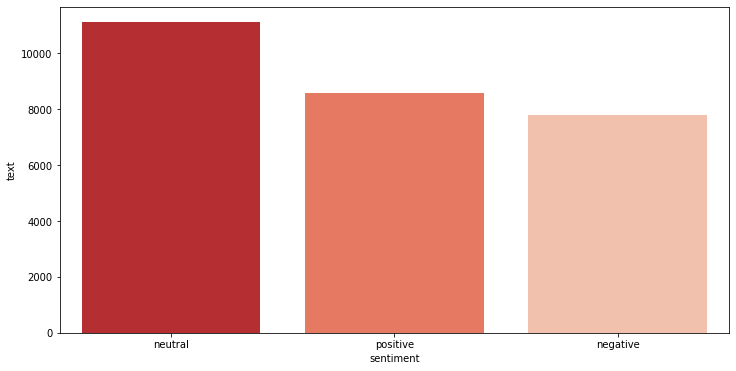

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(x='sentiment', y='text', data=temp, palette='Reds_r') # Visualiztion from table to bar plot

In [ ]:
# Drawing a funnel chart
fig = go.Figure(go.Funnelarea(text = temp.sentiment, values = temp.text, title = {'position': 'top center', 'text': 'Funnel chart of sentiment distribution'}))
# Using plotly because matplotlib doesn't support funnel chart directly
fig.show()

In [ ]:
def jaccard(s1, s2): # Defining Jaccard index function
  a = set(s1.lower().split())
  b = set(s2.lower().split())
  c = a.intersection(b)
  return float( len(c) / (len(a) + len(b) - len(c)) ) # Return the Jaccard index

What's Jaccard index?  
https://en.wikipedia.org/wiki/Jaccard_index

In [ ]:
# Can we decide which tweet belongs to which class? Let's find out.
for var in ['positive', 'negative', 'neutral']:
  temp_jacc = []
  for idx, row in train[train['sentiment']==var].iterrows():
    s1 = row.text
    s2 = row.selected_text

    j = jaccard(s1, s2)
    temp_jacc.append(j)

  print("Mean Jaccard score in {0}: {1}".format(var, np.mean(temp_jacc)))

Mean Jaccard score in positive: 0.31437165005276124
Mean Jaccard score in negative: 0.3386128072742195
Mean Jaccard score in neutral: 0.9764446695278004


Looks like those with high Jaccard indices can be classified as neutral tweet.

In [ ]:
results_jaccard = []

for idx, row in train.iterrows():
  sentence1 = row.text
  sentence2 = row.selected_text

  jacc = jaccard(sentence1, sentence2)
  results_jaccard.append([sentence1, sentence2, jacc])

In [ ]:
jaccard_df = pd.DataFrame(results_jaccard, columns=['text', 'selected_text', 'jacc'])
train = train.merge(jaccard_df, how='outer')

In [ ]:
train['num_words_st'] = train['selected_text'].apply(lambda x: len(str(x).split())) # Number of words in the selected text
train['num_words_text'] = train['text'].apply(lambda x: len(str(x).split())) # Number of words in the main text
train['words_diff'] = train['num_words_text'] - train['num_words_st'] # Difference in the number of words between text and selected text

In [ ]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score,num_words_st,num_words_text,words_diff
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1.000000,7,7,0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.200000,2,10,8
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,2,5,3
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,3,5,2
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0.214286,3,14,11


In [ ]:
hist_data = [train['num_words_st'], train['num_words_text']]

group_labels = ['selected_text', 'text']

fig = ff.create_distplot(hist_data, group_labels, show_curve=False)
fig.update_layout(title_text='Distribution of Number of Words')
fig.update_layout(autosize=False, width=900, height=700, paper_bgcolor='LightSteelBlue')
fig.show()

Apparently, most of the tweets are short.

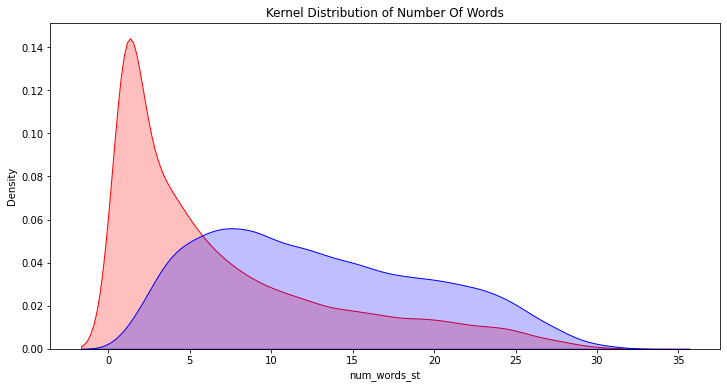

In [ ]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train['num_words_st'], shade=True, color="r").set_title('Kernel Distribution of Number Of Words')
p1=sns.kdeplot(train['num_words_text'], shade=True, color="b")

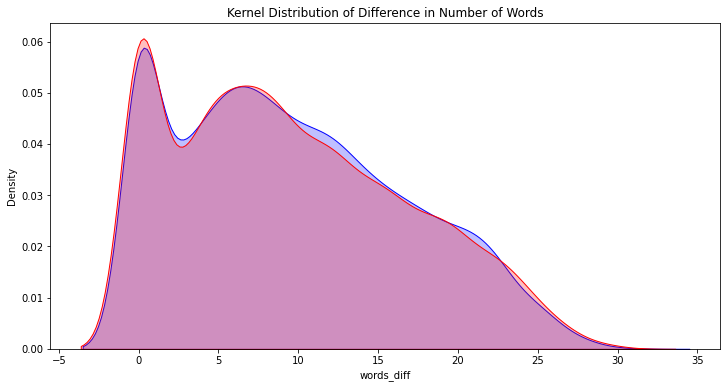

In [ ]:
plt.figure(figsize=(12,6))
arg = [train[train['sentiment']=='positive']['words_diff'], train[train['sentiment']=='negative']['words_diff']]
p1 = sns.kdeplot(train[train['sentiment']=='positive']['words_diff'],
                 shade=True, color='b').set_title('Kernel Distribution of Difference in Number of Words')
p2 = sns.kdeplot(train[train['sentiment']=='negative']['words_diff'],
                 shade=True, color='r')

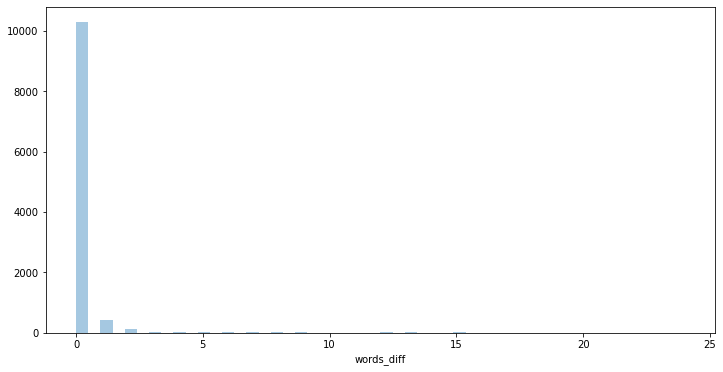

In [ ]:
plt.figure(figsize=(12,6))
sns.distplot(train[train['sentiment']=='neutral']['words_diff'], kde=False)

As we can see, the majority of the differences in words between text and selected_text is 0 (when the tweet has neutral sentiment).  
In fact, this makes sense in that if the tweet is of neutral sentiment, we can't pick a specific word(s) to represent the tweet's feeling.

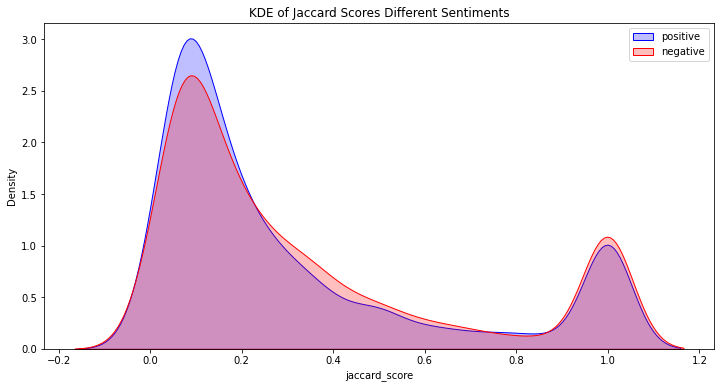

In [ ]:
plt.figure(figsize=(12,6))
p1 = sns.kdeplot(train[train['sentiment']=='positive']['jacc'], shade=True, color='b').set_title('KDE of Jaccard Scores Different Sentiments')
p2 = sns.kdeplot(train[train['sentiment']=='negative']['jacc'], shade=True, color='r')
plt.legend(labels=['positive', 'negative'])

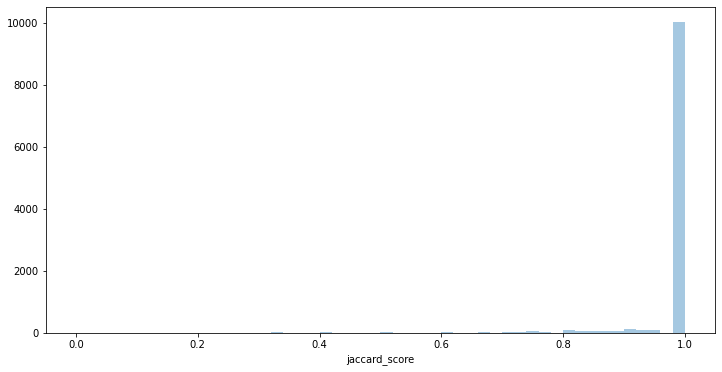

In [ ]:
plt.figure(figsize=(12,6))
sns.distplot(train[train['sentiment']=='neutral']['jaccard_score'], kde=False)

<Figure size 864x432 with 0 Axes>

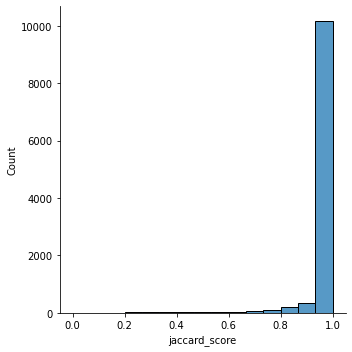

In [ ]:
plt.figure(figsize=(12,6))
sns.displot(train[train['sentiment']=='neutral']['jaccard_score'], kde=False)